<img src="images/JHI_STRAP_Web.png" style="width: 150px; float: right;">

# Supplementary Information: Holmes *et al.* 2017

# 3. Crossvalidation

This notebook describes analysis of 10-fold crossvalidation data of a Bayesian hierarchical model of the effects of control (growth) and treatment (passage) on individual genes from *E. coli* DH10B (carrier) and Sakai (BAC load), to subsets of data obtained using a multi-*E. coli* microarray.

Much of the code for the visualisation, analysis and data manipulation of the fitting results is found in the associated Python module `tools.py`, which should also be present in this directory.

## Table of Contents

 1. [Crossvalidation summary](#summary)
 2. [Load results](#load)
    1. [Load full fit](#loadfit)
    2. [Merge crossvalidation and fit](#merge)    
 3. [Calculate prediction errors](#errors)
    1. [Error distributions](#errdist)
    2. [Error with respect to measured output intensity](#erroutput)
    3. [Error with respect to estimated treatment effect](#errtrt)
    4. [Error with respect to prediction interval](#errinterval)
    5. [Prediction errors for positive treatment effects](#errpos)
 4. [Prediction errors for positive treatment effect candidates](#candidates)
    1. [Plotting distribution of effects](#plot_effects)
    2. [Identifying candidates](#candidates)

<a id="summary"></a>
## Crossvalidation summary

We will be loading predicted and actual *output* probe intensity data from a 10-fold crossvalidation, performed as described in the file `README.md` on the JHI cluster. 

The Stan model used to generate the crossvalidation results is identical in form to that used in the notebook `02-full_model_fit.ipynb` except that it is fit ten times, each time on a random 90% of the data, and a prediction made for the *output* probe intensity of the remaining 10% of the data, given the *input* probe intensity as a predictor. The results of these ten runs are combined in the file `10-fold_CV.tab`.

We can assess the applicability and success of the Stan model by investigating how well it can predict the *output* intensity of a probe, given its *input* intensity. We are conducting crossvalidation on the original data, for which we have measured *input* and *output* intensity data. We consider a prediction to be "correct" if the measured *output* intensity lies within the 90% credibility interval of the *predicted output* intensity.

## Python imports

In [1]:
%pylab inline

import os

import numpy as np
import pandas as pd
import pickle
import scipy
import seaborn as sns

import tools

import warnings
warnings.filterwarnings('ignore')

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


<a id="load"></a>
## Load results

We load data from the multiplexed run performed on the JHI cluster, as described in `README.md`. 

The column containing the experimentally-measured predictor (*input* intensity) is `log_input`, and the column containing the measured *output* probe intensity is `log_output`. 

The *predicted output* mean and median values for 1000 iterations of two chains are found in the columns `y_pred_mean` and `y_pred_median`. 5%, 25%, 75% and 95% percentiles for *predicted output* are given in the columns `y_pred_5pc`, `y_pred_25pc`, `y_pred_75pc` and `y_pred_95pc`. These can be combined to provide 50% and 90% credibility intervals.

In [2]:
# Crossvalidation results file
resultsfile = os.path.join("datasets", "100-fold_CV.tab")

# Load predictions from file
results = pd.read_csv(resultsfile, sep='\t', index_col=0)
print(results.shape)
print(results.columns)

(49872, 19)
Index(['probe', 'replicate', 'treatment', 'repXtrt', 'input', 'output',
       'log_input', 'log_output', 'match', 'locus_tag', 'probe_index',
       'locus_tag_index', 'y_pred_25pc', 'y_pred_5pc', 'y_pred_75pc',
       'y_pred_95pc', 'y_pred_mean', 'y_pred_median', 'y_pred_sem'],
      dtype='object')


In [3]:
results.head()

,probe,replicate,treatment,repXtrt,input,output,log_input,log_output,match,locus_tag,probe_index,locus_tag_index,y_pred_25pc,y_pred_5pc,y_pred_75pc,y_pred_95pc,y_pred_mean,y_pred_median,y_pred_sem
81,A_07_P010704,3,0,rep3trt0,6026.244000,5050.760667,8.703879,8.527294,lcl|NC_010473.1_cds_WP_001264707.1_2,ECDH10B_RS00010,7283,5515,8.195164,7.752530,8.752007,9.212968,8.472144,8.462348,0.429291
262,A_07_P010704,1,0,rep1trt0,6121.405000,4410.934000,8.719547,8.391842,lcl|NC_010473.1_cds_WP_001264707.1_2,ECDH10B_RS00010,7283,5515,8.237067,7.801046,8.805119,9.189360,8.519575,8.528116,0.427607
47,A_07_P010704,2,1,rep2trt1,1885.536667,1251.527667,7.541968,7.132120,lcl|NC_010473.1_cds_WP_001264707.1_2,ECDH10B_RS00010,7283,5515,7.033256,6.589159,7.577049,8.061466,7.318810,7.327469,0.434528
443,A_07_P010704,2,0,rep2trt0,7012.786667,4197.077333,8.855490,8.342144,lcl|NC_010473.1_cds_WP_001264707.1_2,ECDH10B_RS00010,7283,5515,8.332483,7.948296,8.885430,9.291693,8.623536,8.631724,0.412262
375,A_07_P010704,1,1,rep1trt1,1759.515333,1240.375333,7.472794,7.123169,lcl|NC_010473.1_cds_WP_001264707.1_2,ECDH10B_RS00010,7283,5515,6.982428,6.592854,7.590789,8.043161,7.297764,7.281349,0.445194


The crossvalidation data has 49872 rows (one per probe, per experiment) and 20 columns, named as shown.

<a id="loadfit"></a>
### Load full fit

We will want to investigate how predictive performance compares with our estimate of parameters from a fit on full data, to see - for example - whether the genes for which we have confidence in a treatment effect are associated with good predictions of output probe intensity.

We load the model fit from notebook `02-full_model_fit.ipynb`.

In [4]:
# File containing pickled fit from notebook 02
fitfile = os.path.join("model_fits", "full_model_fit.pkl")

# Load array measurements and get locus tags
datafile = os.path.join("datasets", "normalised_array_data.tab")
indata = pd.read_csv(datafile, sep="\t")
locus_tags = indata['locus_tag'].unique()

# Load the pickled fit into `estimates`
fit = pickle.load(open(fitfile, 'rb'))
estimates = tools.extract_variable_summaries(fit, 'df', locus_tags)
estimates.head()  # inspect the data

,locus_tag,a_2.5pc,a_25pc,a_75pc,a_97.5pc,a_mean,a_median,a_sem,b_2.5pc,b_25pc,...,g_mean,g_median,g_sem,d_2.5pc,d_25pc,d_75pc,d_97.5pc,d_mean,d_median,d_sem
5515,ECDH10B_RS00010,0.029129,0.244940,0.332219,0.426666,0.276330,0.295267,0.097412,0.918105,0.937876,...,0.373606,0.386956,0.091973,-0.090580,-0.062259,-0.055452,-0.036866,-0.059451,-0.058879,0.011430
4705,ECDH10B_RS00020,0.169773,0.272327,0.336390,0.427064,0.303134,0.305796,0.060675,0.923711,0.938501,...,0.385294,0.391275,0.064762,-0.079569,-0.062273,-0.054959,-0.044358,-0.059307,-0.058405,0.008574
5475,ECDH10B_RS00060,0.092371,0.268534,0.338677,0.493763,0.297471,0.307758,0.099552,0.916767,0.938826,...,0.383268,0.389446,0.073516,-0.089941,-0.063986,-0.055564,-0.036741,-0.060844,-0.059464,0.012340
5474,ECDH10B_RS00065,0.091092,0.258078,0.334934,0.449760,0.294165,0.302821,0.081867,0.907745,0.938434,...,0.385307,0.391122,0.106802,-0.090234,-0.062454,-0.054761,-0.040138,-0.059514,-0.058488,0.011435
5469,ECDH10B_RS00070,0.083468,0.265716,0.334018,0.413204,0.291290,0.301167,0.073938,0.918311,0.938084,...,0.373458,0.389639,0.107962,-0.130703,-0.067450,-0.056503,-0.047106,-0.068497,-0.059957,0.022810


`estimates` contains the notebook `02-full_model_fit.ipynb` estimates of parameters for each gene, with percentiles enabling a 95% or 50% credibility interval to be estimated.

<a id="merge"></a>
### Merge crossvalidation and fit

We join the crossvalidation data with the fits for the corresponding genes, on the basis of `locus_tag`, to make plotting and analysis easier. We also reduce the columns in the dataset to the locus tag, probe ID, the treatment and replicate factor, the measured log-transformed *input* and *output* intensities, and the median and 90% CI for the *predicted output* intensity. We also keep the estimated median $\delta$ and associated 95% CI.

In [5]:
# Columns to keep from the merged data
resultscols = ['locus_tag', 'probe', 'replicate', 'treatment',
               'log_input', 'log_output', 'y_pred_5pc', 'y_pred_median', 'y_pred_95pc',
               'd_2.5pc', 'd_25pc', 'd_median', 'd_75pc', 'd_97.5pc']

# Merge fit estimates with observed data
results_merged = pd.merge(results, estimates,
                          how='outer',
                          left_on='locus_tag', right_on='locus_tag').loc[:, resultscols]
results_merged.head()

,locus_tag,probe,replicate,treatment,log_input,log_output,y_pred_5pc,y_pred_median,y_pred_95pc,d_2.5pc,d_25pc,d_median,d_75pc,d_97.5pc
0,ECDH10B_RS00010,A_07_P010704,3,0,8.703879,8.527294,7.752530,8.462348,9.212968,-0.09058,-0.062259,-0.058879,-0.055452,-0.036866
1,ECDH10B_RS00010,A_07_P010704,1,0,8.719547,8.391842,7.801046,8.528116,9.189360,-0.09058,-0.062259,-0.058879,-0.055452,-0.036866
2,ECDH10B_RS00010,A_07_P010704,2,1,7.541968,7.132120,6.589159,7.327469,8.061466,-0.09058,-0.062259,-0.058879,-0.055452,-0.036866
3,ECDH10B_RS00010,A_07_P010704,2,0,8.855490,8.342144,7.948296,8.631724,9.291693,-0.09058,-0.062259,-0.058879,-0.055452,-0.036866
4,ECDH10B_RS00010,A_07_P010704,1,1,7.472794,7.123169,6.592854,7.281349,8.043161,-0.09058,-0.062259,-0.058879,-0.055452,-0.036866


<a id="errors"></a>
## Calculate prediction error

We create two new columns to represent the error in crossvalidation prediction of *output* intensity:

* `y_pred_abs_error`: the absolute error (`y_pred_median` - `log_output`)
* `y_pred_rel_error`: the relative error (`y_pred_abs_error`/`log_output`)

In [6]:
# Calculate absolute and relative prediction error
results_merged['y_pred_abs_error'] = results_merged['y_pred_median'] - results_merged['log_output']
results_merged['y_pred_rel_error'] = results_merged['y_pred_abs_error']/results_merged['log_output']

<a id="errdist"></a>
### Error distributions

Inspect the distribution of these errors directly by plotting, there are some strongly outlying points with large error, but most prediction errors are close to zero.

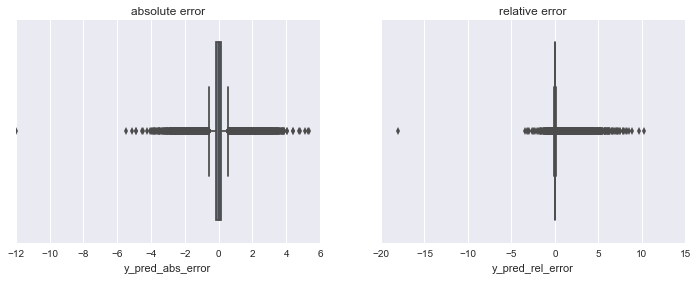

In [7]:
# Plot prediction errors boxplots
tools.plot_errors(results_merged)

<a id="erroutput"></a>
### Error with respect to measured intensity

By plotting the absolute and relative error in *output* intensity prediction against measured values, we can get an idea of whether the errors are uniformly distributed, or likely to be associated with weak measured intensities.

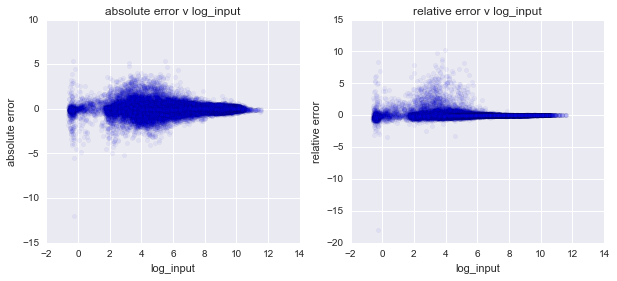

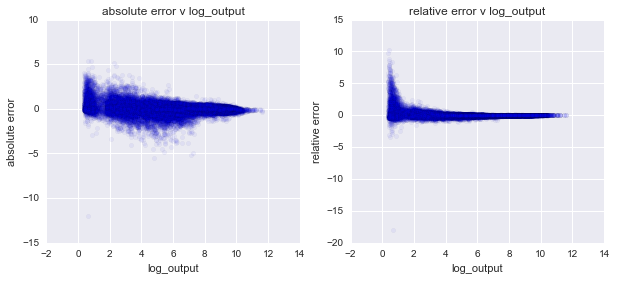

In [8]:
# Plot relative and absolute error wrt input and output
tools.plot_error_vs_column(results_merged, "log_input")
tools.plot_error_vs_column(results_merged, "log_output")

The plots above indicate that absolute and relative prediction errors are small for probes with intensities of 8 or less. In particular, probes with strong intensities have very low absolute and relative error. 

<a id="errtrt"></a>
### Error with respect to estimated treatment effect

By relating the absolute and relative error to the estimated treatment effect, we can interpret whether we should continue to be confident in the results of notebook 02. If the 25% percentile for our estimate of $\delta$ is greater than zero, then the 50% CI for that probe's gene does not include zero, and we interpret this as a positive effect due to treatment.

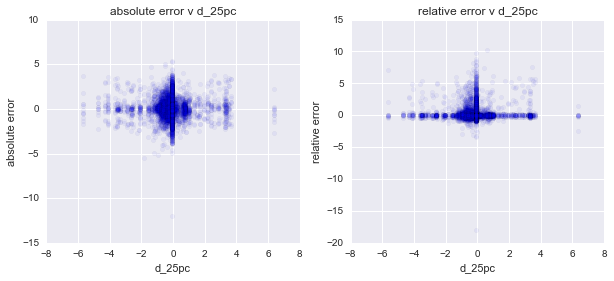

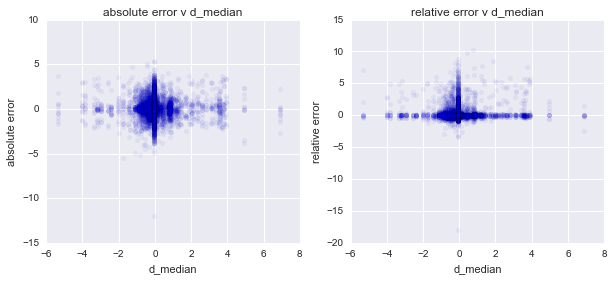

In [9]:
# Plot errors relative to 25% percentile for estimate of treatment effect
tools.plot_error_vs_column(results_merged, "d_25pc")
tools.plot_error_vs_column(results_merged, "d_median")

Median and 25% percentile values of $\delta_{j[i]}$ close to zero are associate most frequently with large errors. There are also some large absolute and relative errors associated with values that are positive and quite far from zero.

We subset the data to investigate this more closely, in the dataset `trt_pos` representing 72 locus tags with an estimated positive treatment effect.

In [10]:
# Subset data to positive estimates of delta only
trt_pos = results_merged[results_merged['d_25pc'] > 0]
trt_pos.head()

,locus_tag,probe,replicate,treatment,log_input,log_output,y_pred_5pc,y_pred_median,y_pred_95pc,d_2.5pc,d_25pc,d_median,d_75pc,d_97.5pc,y_pred_abs_error,y_pred_rel_error
14484,ECs0213,A_07_P049262,3,0,6.592315,5.044490,4.406037,5.410837,6.388245,-0.055868,0.277769,0.371717,0.460748,0.612089,0.366347,0.072623
14485,ECs0213,A_07_P059522,3,1,3.917283,0.557127,0.066554,1.404111,2.556364,-0.055868,0.277769,0.371717,0.460748,0.612089,0.846983,1.520269
14486,ECs0213,A_07_P049262,2,0,7.441772,7.189409,5.584688,6.353787,7.151539,-0.055868,0.277769,0.371717,0.460748,0.612089,-0.835622,-0.116230
14487,ECs0213,A_07_P059522,1,1,4.621135,1.330718,1.920004,2.659119,3.363234,-0.055868,0.277769,0.371717,0.460748,0.612089,1.328401,0.998258
14488,ECs0213,A_07_P059522,2,0,7.496969,7.205162,6.467671,7.242039,8.103510,-0.055868,0.277769,0.371717,0.460748,0.612089,0.036877,0.005118


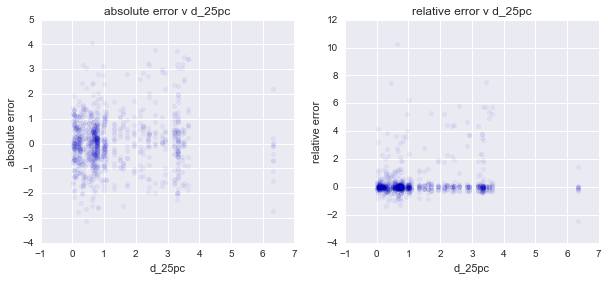

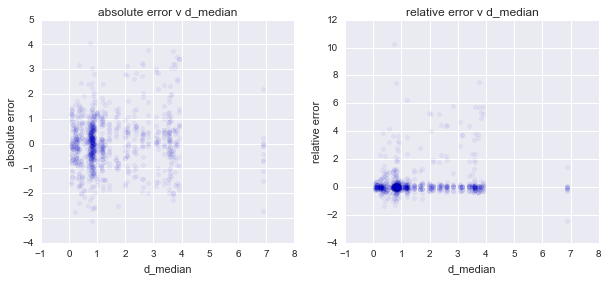

In [11]:
# Plot errors relative to 25% percentile for estimate of treatment effect
tools.plot_error_vs_column(trt_pos, "d_25pc")
tools.plot_error_vs_column(trt_pos, "d_median")

By visual inspection, most probe prediction errors are small in relative terms, but uniformly distributed in absolute terms. We can examine the error distributions for these probes with respect to log *input* and *output* intensities, as above.

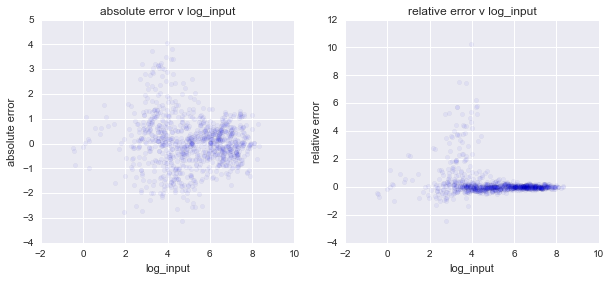

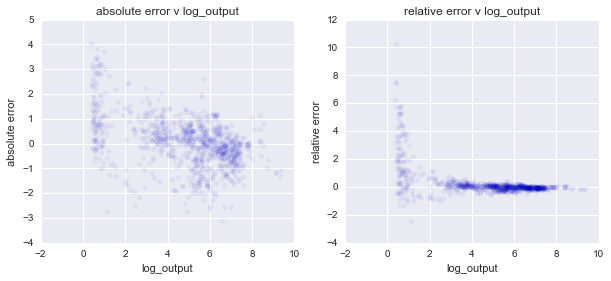

In [12]:
# Plot errors for positive treatment effects wrt measured intensities
tools.plot_error_vs_column(trt_pos, "log_input")
tools.plot_error_vs_column(trt_pos, "log_output")

These plots show that a large relative prediction error is clearly associated only with probes that have low measured *input* or *output* intensity.

<a id="errinterval"></a>
### Error with respect to prediction interval

As an estimate of prediction accuracy, we can calculate the number of observed output intensities that lie outwith the 90% credibility interval of the prediction. We create the column `pred_success`, which contains `True` where the predicted *output* value lies in the 90% CI for the crossvalidation predictions.

In [13]:
# Add a column for probe predictions that lie outwith the 90% credibility interval of prediction
results_merged['pred_success'] = (results_merged['log_output'] > results_merged['y_pred_5pc']) & (results_merged['log_output'] < results_merged['y_pred_95pc'])
results_merged.head()

,locus_tag,probe,replicate,treatment,log_input,log_output,y_pred_5pc,y_pred_median,y_pred_95pc,d_2.5pc,d_25pc,d_median,d_75pc,d_97.5pc,y_pred_abs_error,y_pred_rel_error,pred_success
0,ECDH10B_RS00010,A_07_P010704,3,0,8.703879,8.527294,7.752530,8.462348,9.212968,-0.09058,-0.062259,-0.058879,-0.055452,-0.036866,-0.064946,-0.007616,True
1,ECDH10B_RS00010,A_07_P010704,1,0,8.719547,8.391842,7.801046,8.528116,9.189360,-0.09058,-0.062259,-0.058879,-0.055452,-0.036866,0.136275,0.016239,True
2,ECDH10B_RS00010,A_07_P010704,2,1,7.541968,7.132120,6.589159,7.327469,8.061466,-0.09058,-0.062259,-0.058879,-0.055452,-0.036866,0.195349,0.027390,True
3,ECDH10B_RS00010,A_07_P010704,2,0,8.855490,8.342144,7.948296,8.631724,9.291693,-0.09058,-0.062259,-0.058879,-0.055452,-0.036866,0.289580,0.034713,True
4,ECDH10B_RS00010,A_07_P010704,1,1,7.472794,7.123169,6.592854,7.281349,8.043161,-0.09058,-0.062259,-0.058879,-0.055452,-0.036866,0.158180,0.022206,True


In [14]:
# Make a dataframe of missed predictions
errors = results_merged[results_merged['pred_success'] == False]
print(errors.shape, results_merged.shape, len(errors['locus_tag'].unique()))

(4156, 17) (49872, 17) 1142


This identifies 4156/49872 probe predictions (an 8% misprediction rate!), covering 1142 locus_tags in total.

We can gain an insight into the number of probes that are likely to be in error for any particular locus tag, by plotting the distribution of their counts:

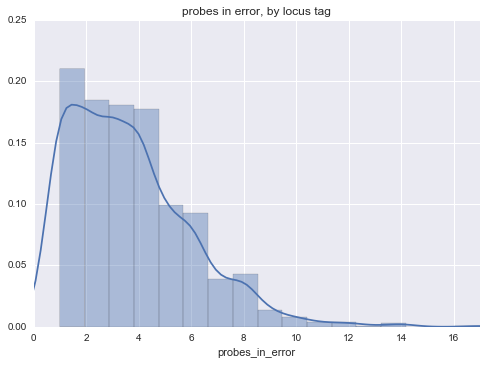

In [15]:
# Distribution of probes in error, by locus tag
error_probe_counts = errors['locus_tag'].groupby(errors['locus_tag']).agg(['count'])
error_probe_counts.columns=['probes_in_error']
ax = sns.distplot(error_probe_counts['probes_in_error'], bins=max(error_probe_counts['probes_in_error']))
ax.set_title("probes in error, by locus tag")
ax.set_xlim(0, max(error_probe_counts['probes_in_error']));

Most of the locus tags have errors in 3 probes or fewer (out of an average of six or so), so in general we might expect most locus tags to be relatively well-predicted by our model. 

But is this the case for the locus tags with a predicted positive treatment effect?

<a id="#errpos"></a>
### Prediction errors for positive treatment effects

We can examine the distribution of crossvalidation prediction errors for the locus tags with positive estimated treatment effect, and compare this to the distribution for the dataset as a whole. If these are similar, then there may be no systematic misprediction for the positive estimated treatment values.

In [16]:
# Subset data to positive estimates of delta only
trt_pos = results_merged[results_merged['d_25pc'] > 0]
trt_errors = trt_pos[trt_pos['pred_success'] == False]
print(trt_errors.shape, trt_pos.shape, len(trt_errors['locus_tag'].unique()))

(321, 17) (966, 17) 68


We find that 321/966 of our probes have measured output intensity that lies outwith the 90% CI for the corssvalidation prediction. This is a considerably higher rate than for the dataset as a whole.

Plotting the distribution of the number of probes in error for each locus tag also shows a different distribution to that for the main dataset:

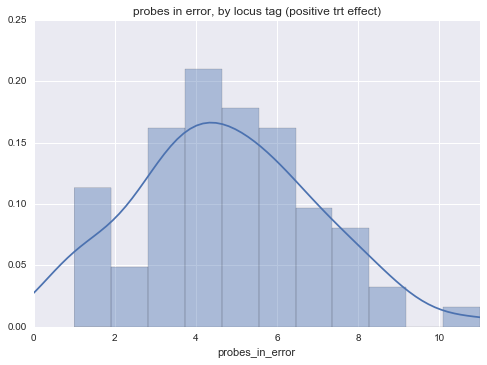

In [17]:
trt_error_probe_counts = trt_errors['locus_tag'].groupby(trt_errors['locus_tag']).agg(['count'])
trt_error_probe_counts.columns=['probes_in_error']
ax = sns.distplot(trt_error_probe_counts['probes_in_error'], bins=max(trt_error_probe_counts['probes_in_error']))
ax.set_title("probes in error, by locus tag (positive trt effect)")
ax.set_xlim(0, max(trt_error_probe_counts['probes_in_error']));

The modal number of probes in error is five, and the distribution has quite a different shape to that for the complete dataset, suggesting a systematic failure of the model to predict precisely the *output* intensity for these probes.

<a id="candidates"></a>
## Prediction (Type S) errors for positive treatment effect candidates

In [18]:
def plot_probe_predictions(locustag, df):
    """Plot prediction range and measured value for a specific gene"""
    ltdata = df.loc[df['locus_tag'] == locustag].sort_values(['probe', 'treatment', 'replicate'])
    plt.scatter(range(len(ltdata)), ltdata['log_output'], color='k')
    for idx, obs, plo, pmd, phi in zip(range(len(ltdata)),
                                       ltdata['log_output'],
                                       ltdata['y_pred_5pc'],
                                       ltdata['y_pred_median'],
                                       ltdata['y_pred_95pc']):
        if plo < obs < phi:
            lcolor = 'b-'
            pcolor = 'b.'
        else:
            lcolor = 'r-'
            pcolor = 'r.'
        plt.plot([idx, idx], [plo, phi], lcolor)
        plt.plot([idx, idx], [pmd, pmd], pcolor)
    plt.xticks(range(len(ltdata)), ltdata['probe'], rotation=90)
    plt.xlim(-1, len(ltdata))
    plt.title("Probe predictions: {0}, delta: {1}".format(locustag, ltdata['d_median'].unique()))

In [19]:
def plot_locustag_predictions(df, tag):
    """Plot prediction range and measured output for a locus tag
    
    Produce one axis per probe
    """
    ltdata = df.loc[df['locus_tag'] == tag].sort_values(['treatment', 'probe', 'replicate'])
    #print(ltdata)
    probes = list(ltdata['probe'].unique())
    numprobes = len(probes)
    fig, axes = plt.subplots(1, numprobes, figsize=(6 * numprobes, 6))
    try:
        axes = axes.ravel()
    except AttributeError:
        axes = (axes,)
    for ttl, arr, ax in zip(probes,
                            [ltdata[ltdata['probe'] == p] for p in probes],
                            axes):
        # Plot input (grey) and output (black) measurements
        ax.scatter(range(len(arr)), arr['log_input'], color='k', alpha=0.2)        
        ax.scatter(range(len(arr)), arr['log_output'], color='k')
        # Plot prediciton errors
        for idx, obs, trt, plo, pmd, phi in zip(range(len(arr)),
                                                arr['log_output'],
                                                arr['treatment'],
                                                arr['y_pred_5pc'],
                                                arr['y_pred_median'],
                                                arr['y_pred_95pc']):
            if plo < obs < phi:
                if trt == 1:
                    lcolor = 'b-'
                    pcolor = 'b.'
                else:
                    lcolor = 'y-'
                    pcolor = 'y.'
            else:
                if trt == 1:
                    lcolor = 'r-'
                    pcolor = 'r.'
                else:
                    lcolor = 'g-'
                    pcolor = 'g.'
            ax.plot([idx, idx], [plo, phi], lcolor)
            ax.plot([idx, idx], [pmd, pmd], pcolor)
        ax.set_title("{2} probe predictions: {0}, delta: {1}".format(ttl,
                                                                     arr['d_median'].unique(),
                                                                     tag))

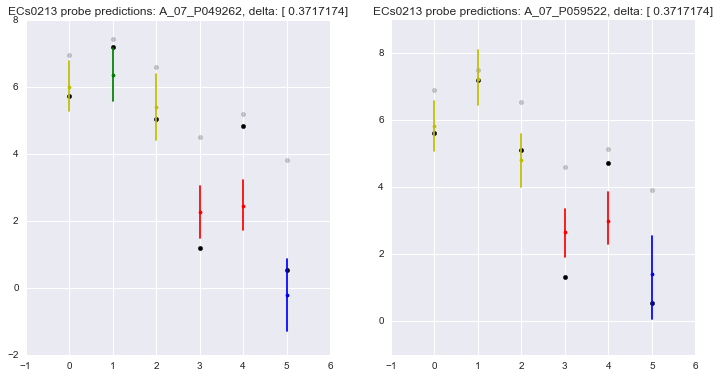

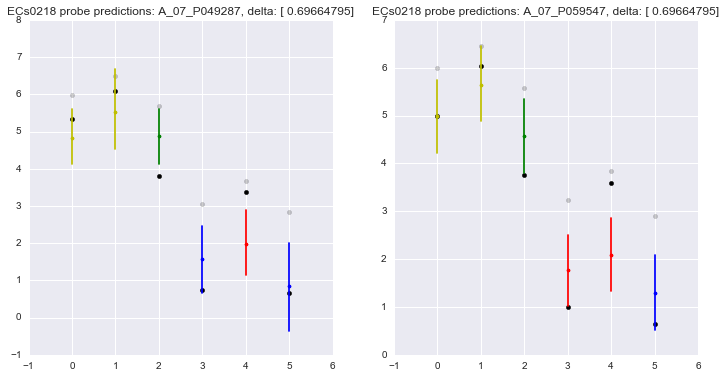

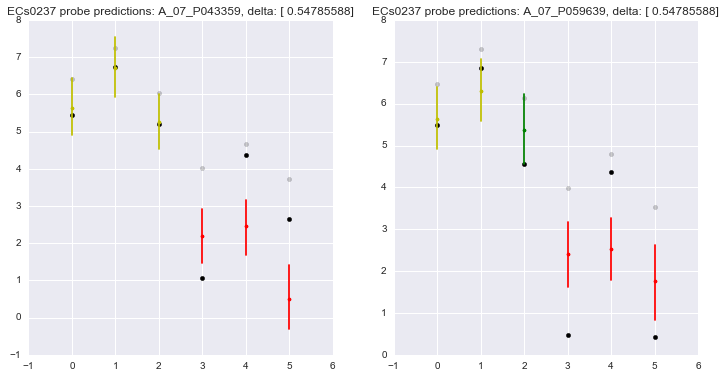

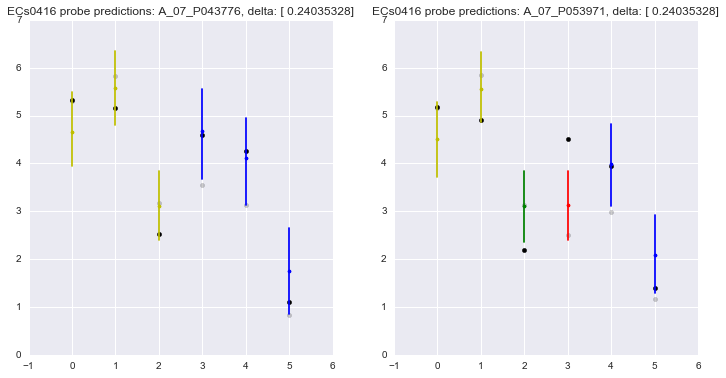

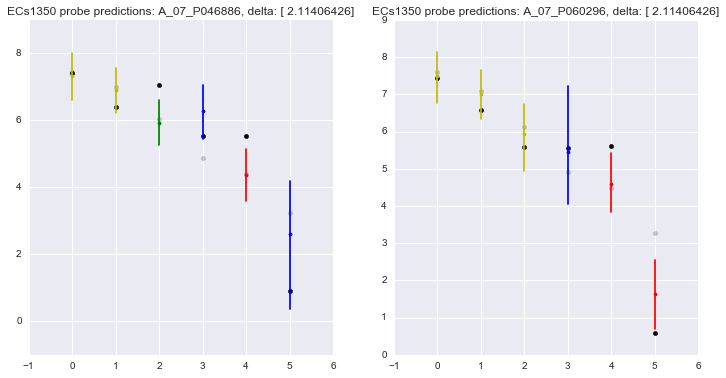

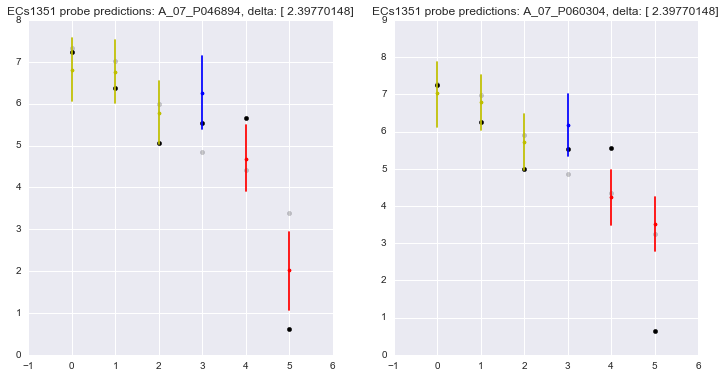

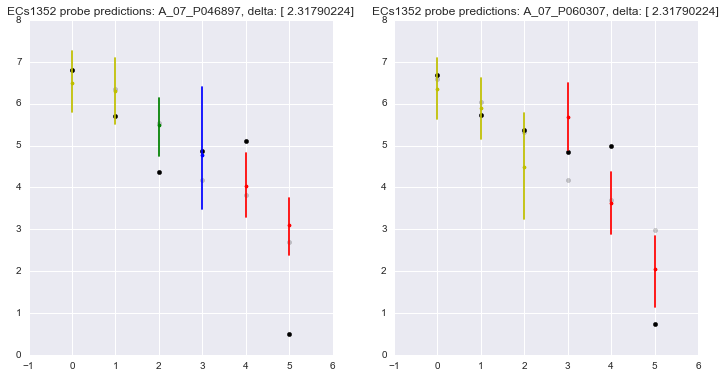

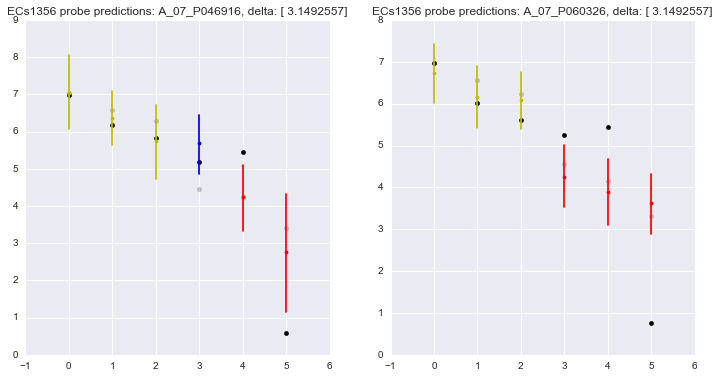

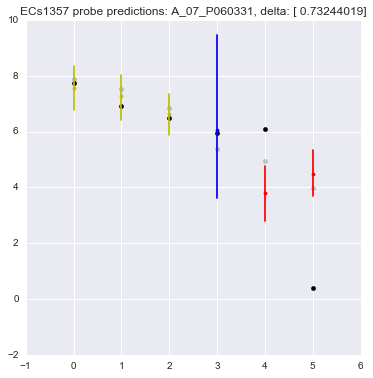

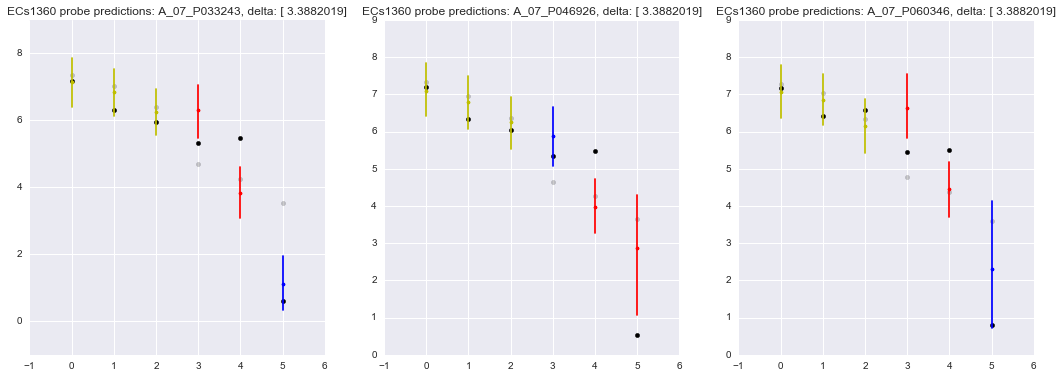

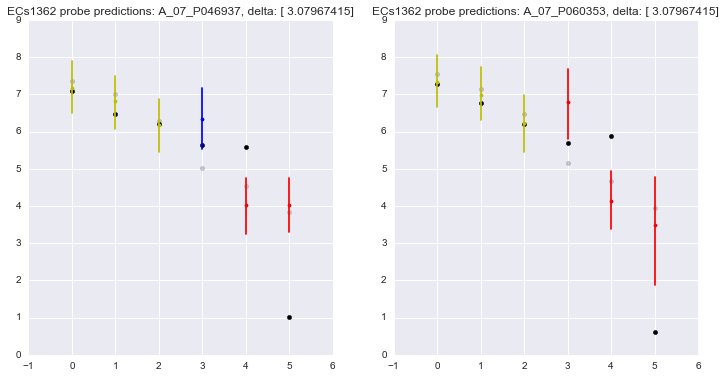

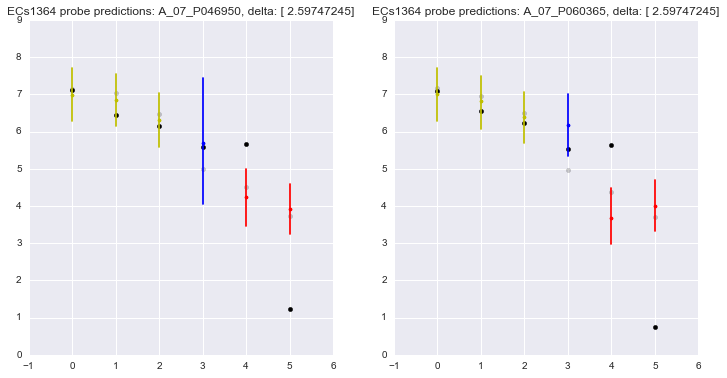

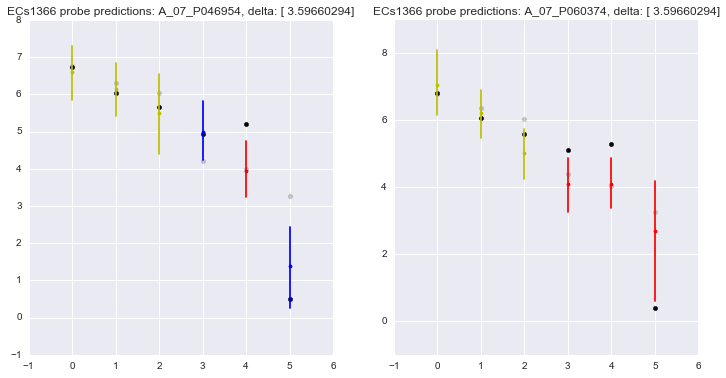

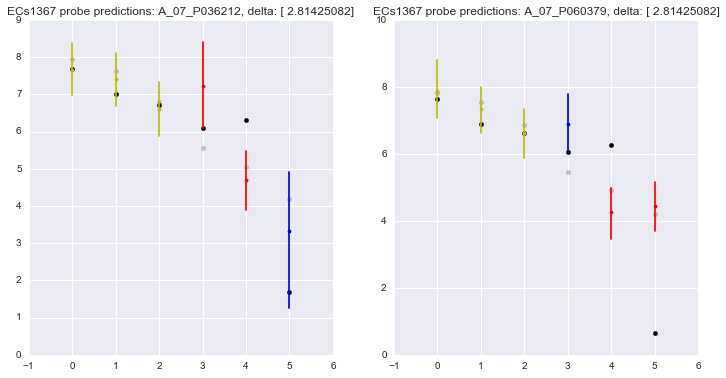

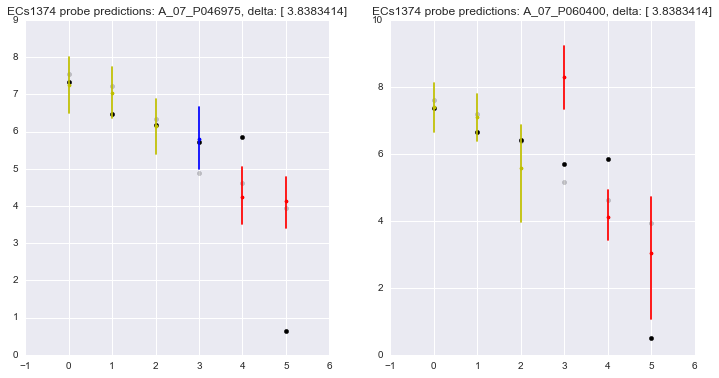

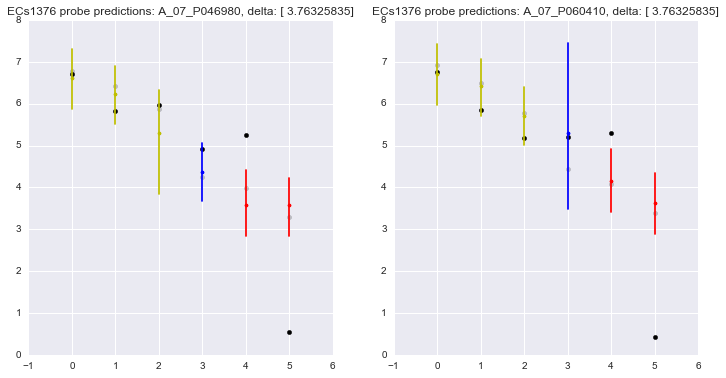

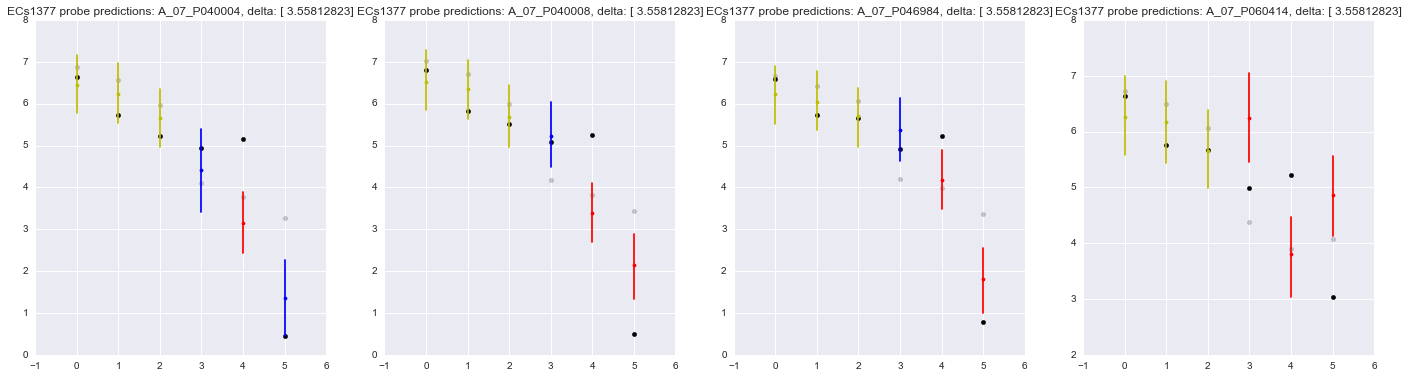

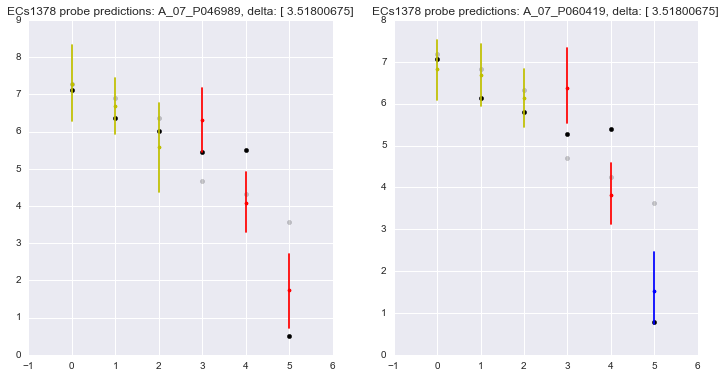

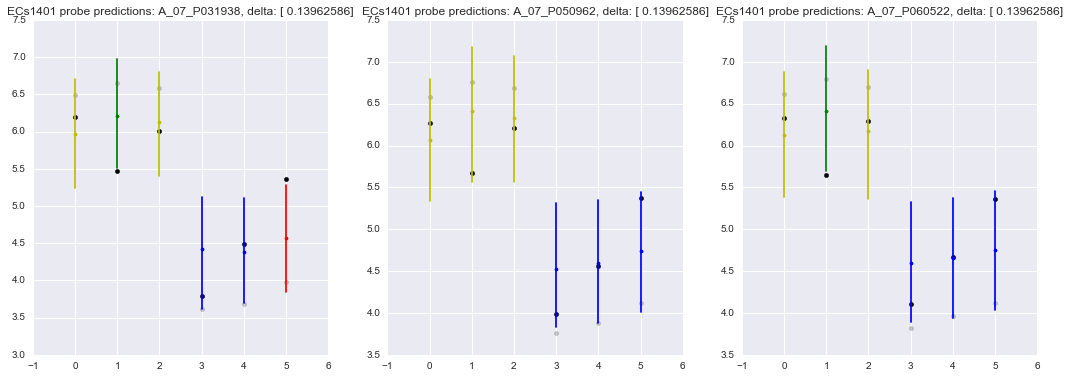

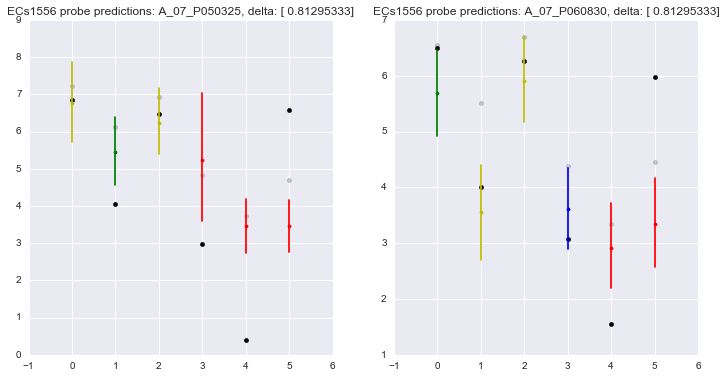

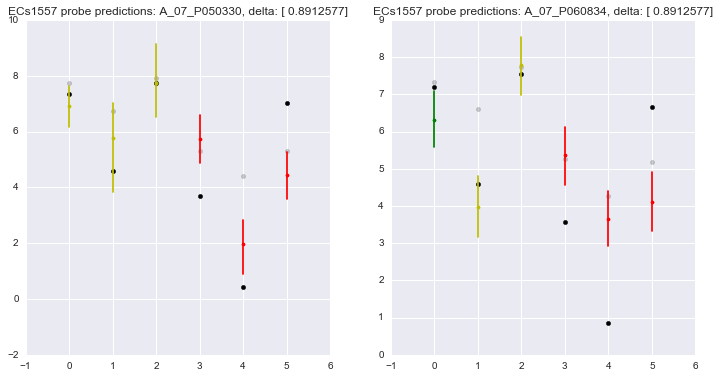

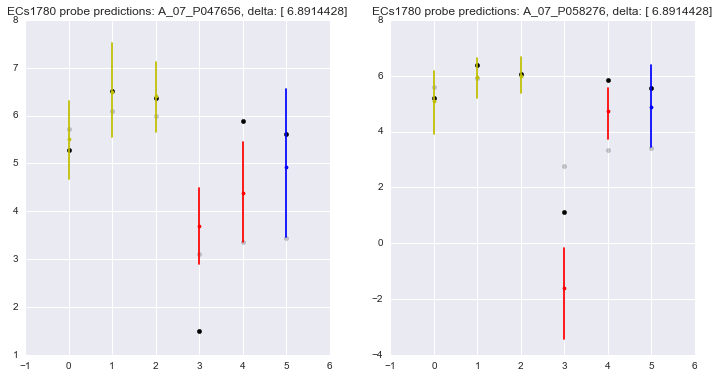

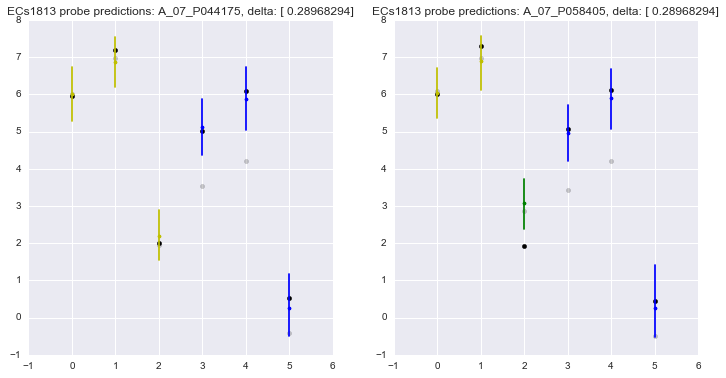

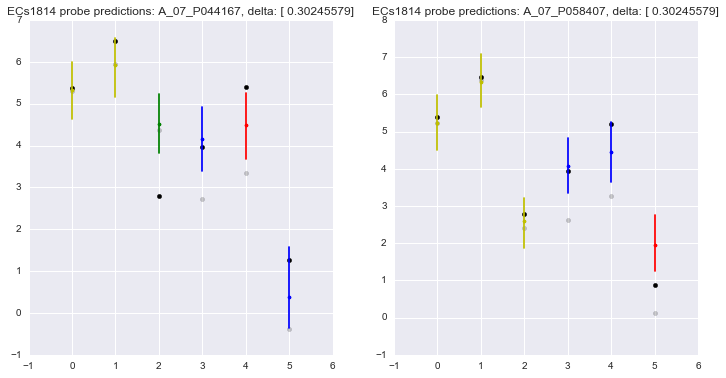

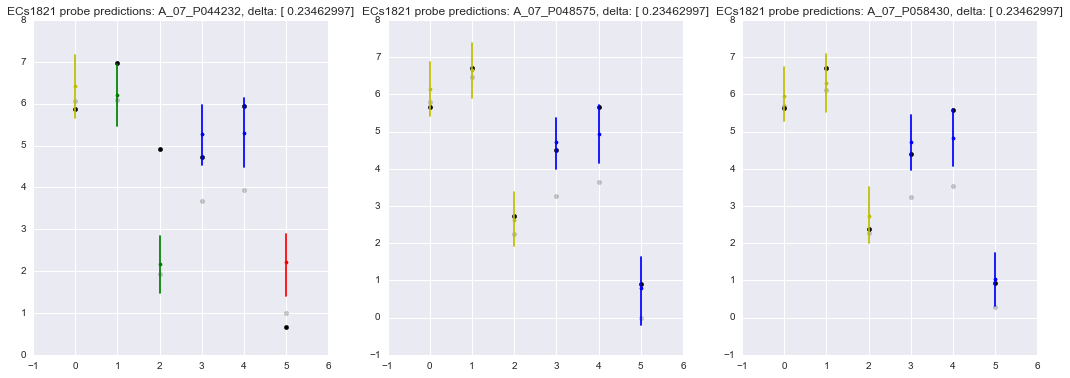

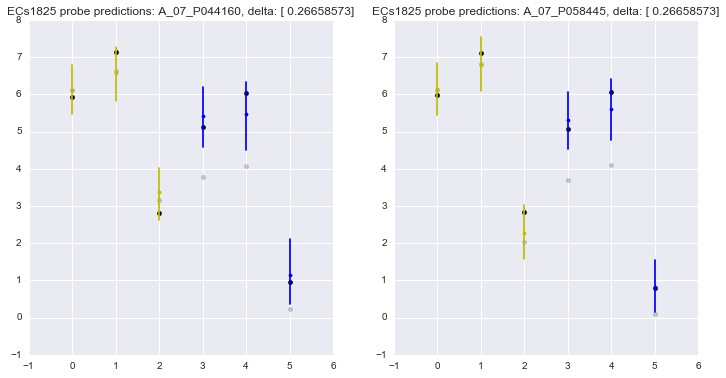

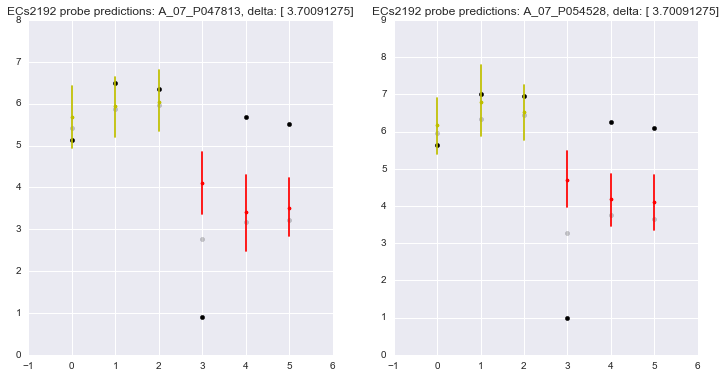

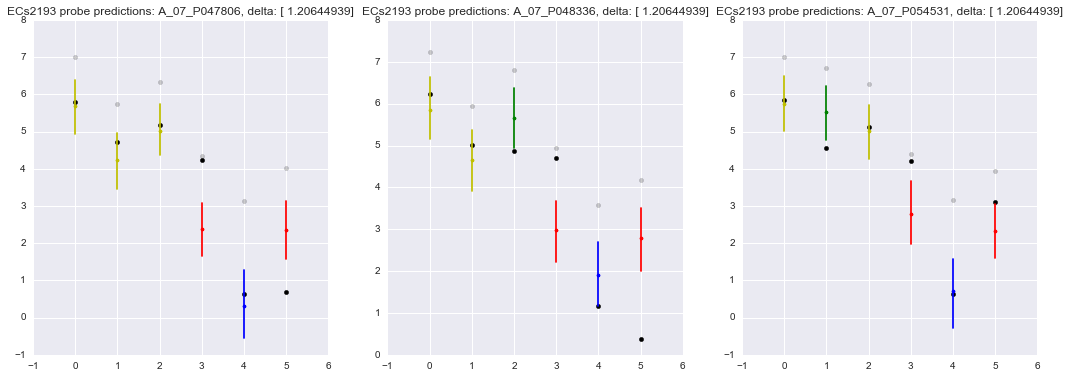

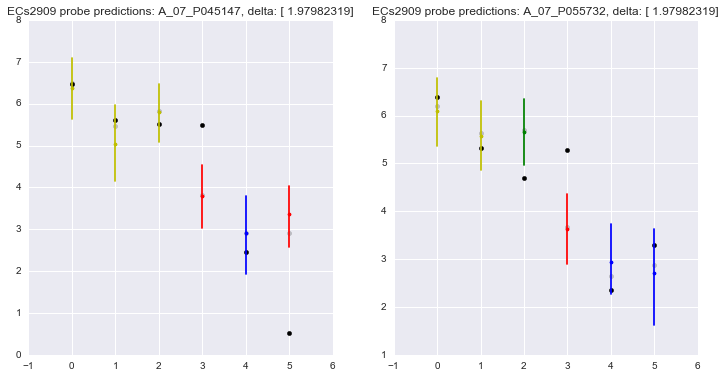

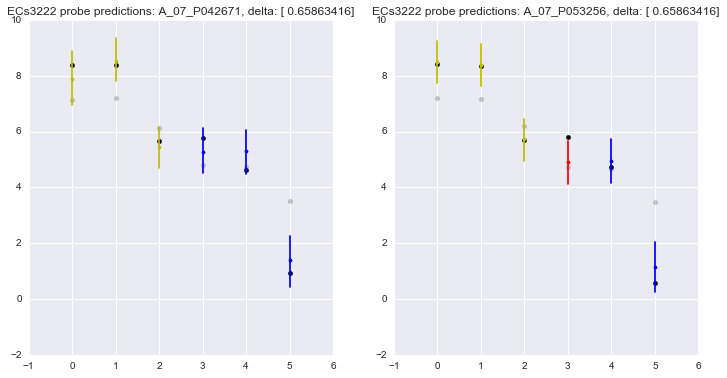

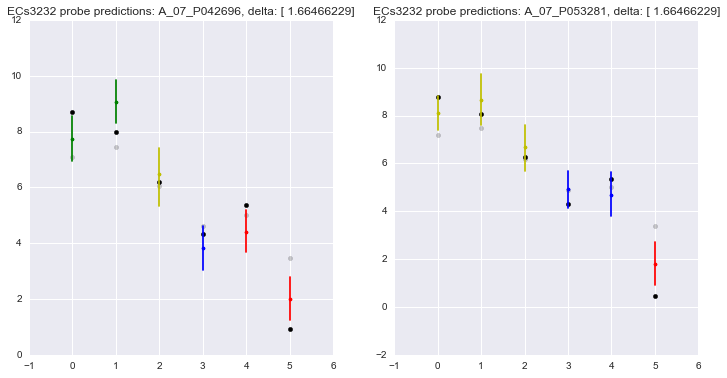

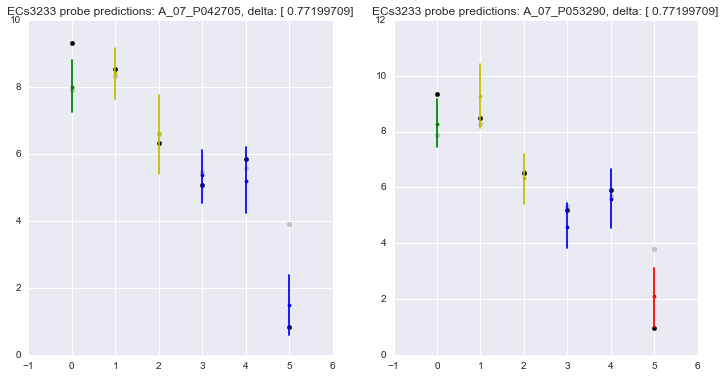

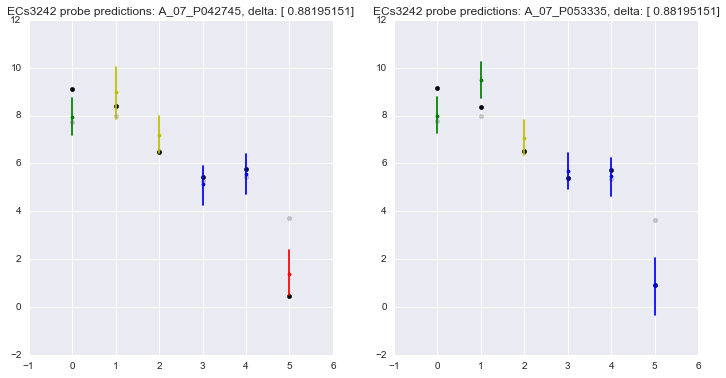

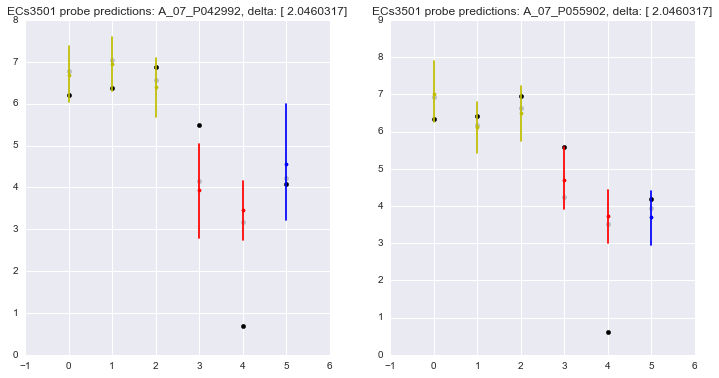

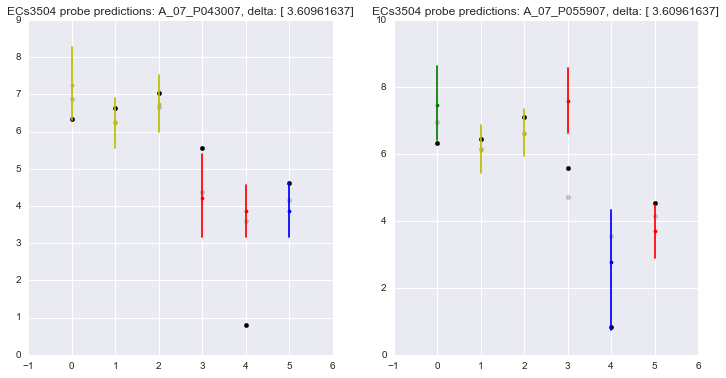

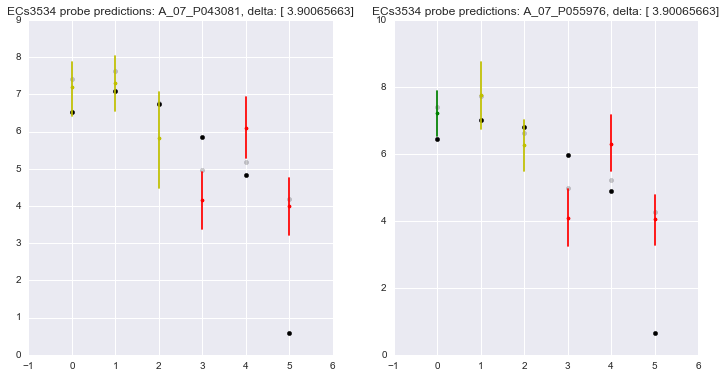

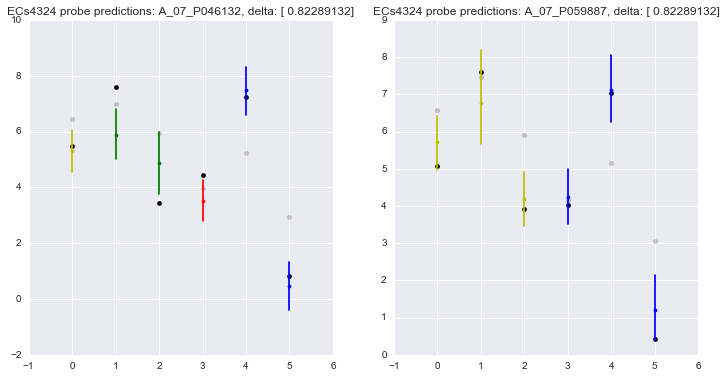

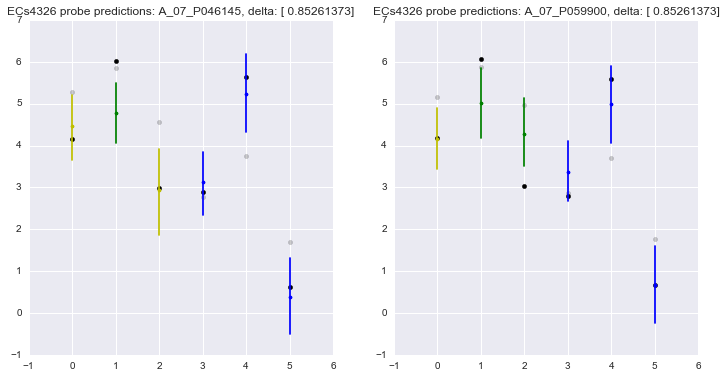

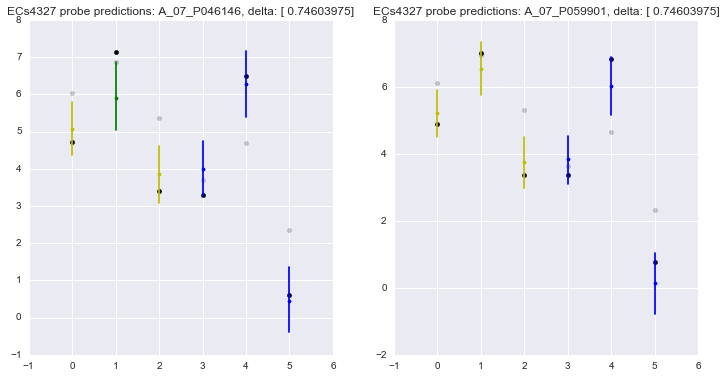

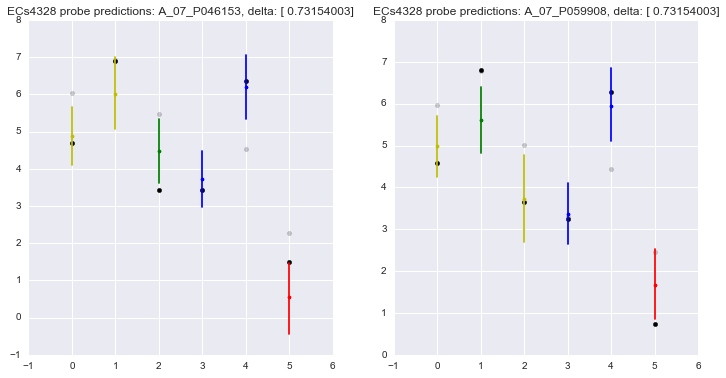

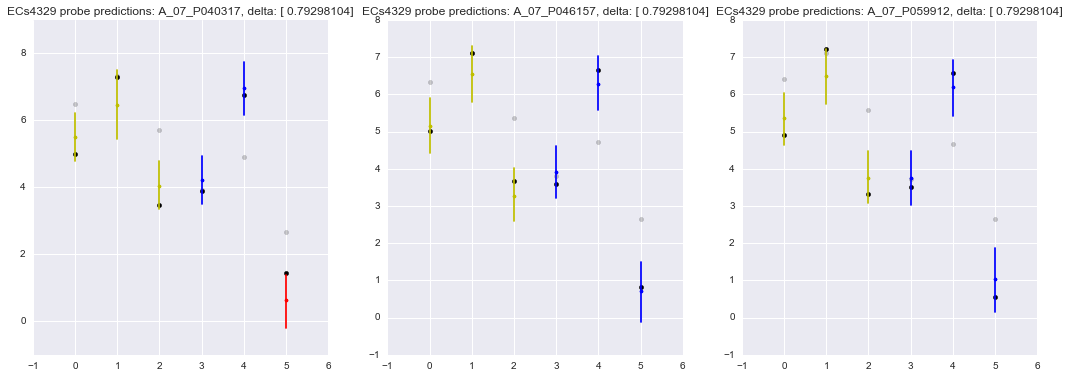

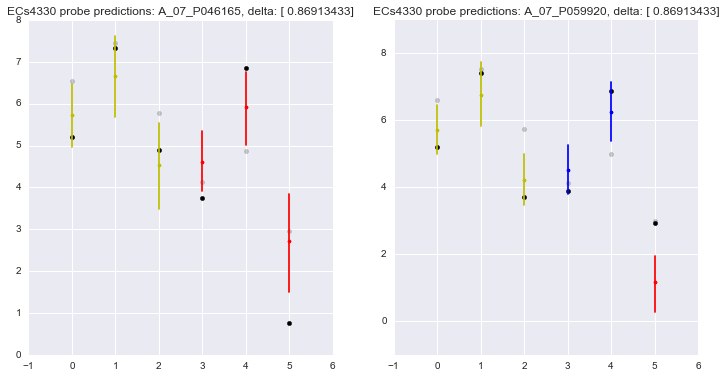

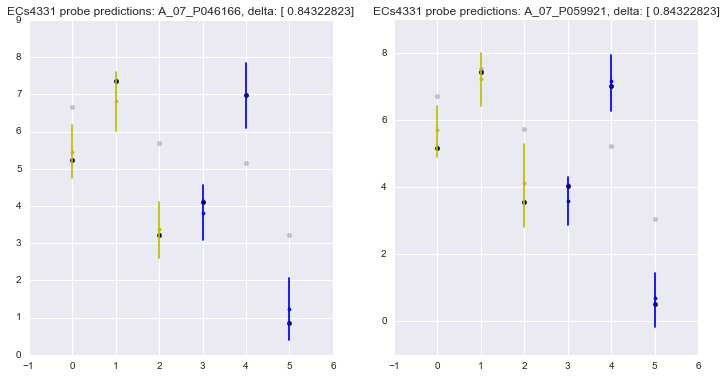

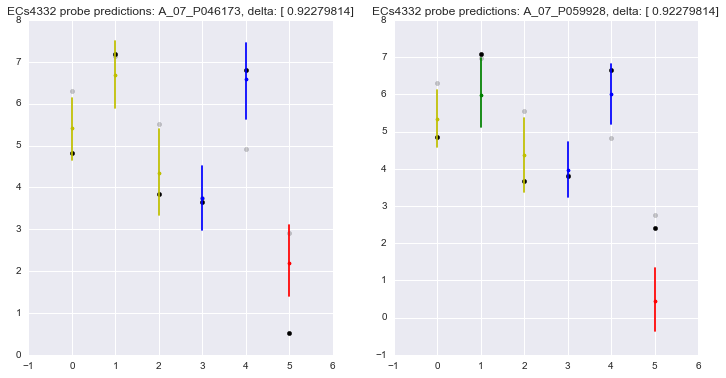

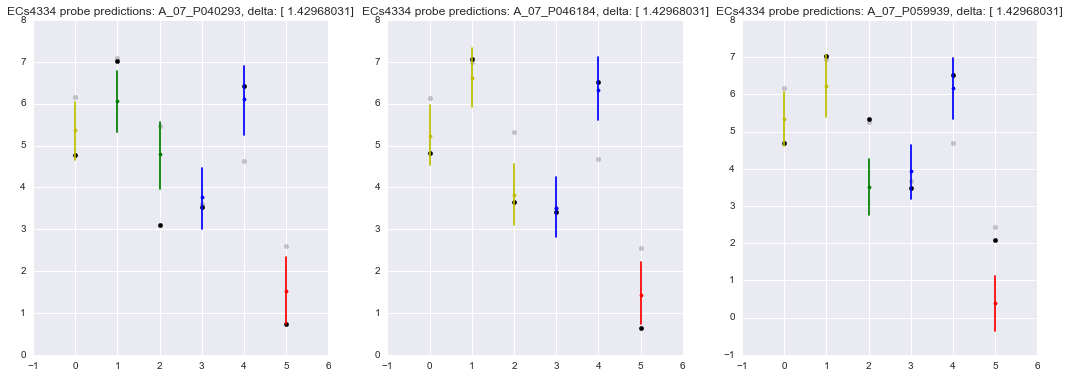

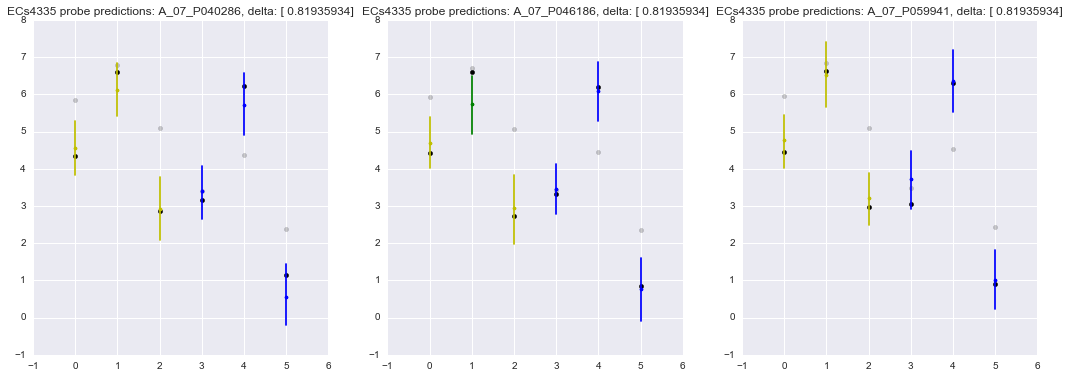

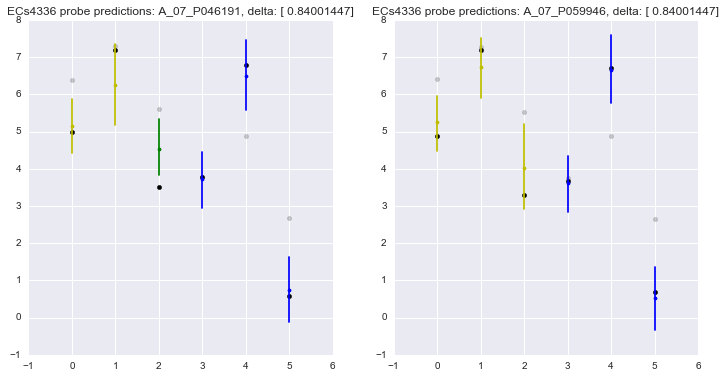

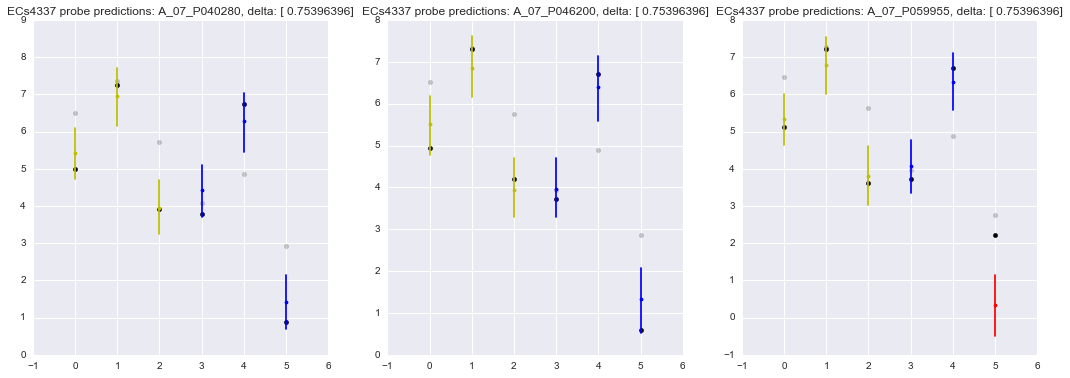

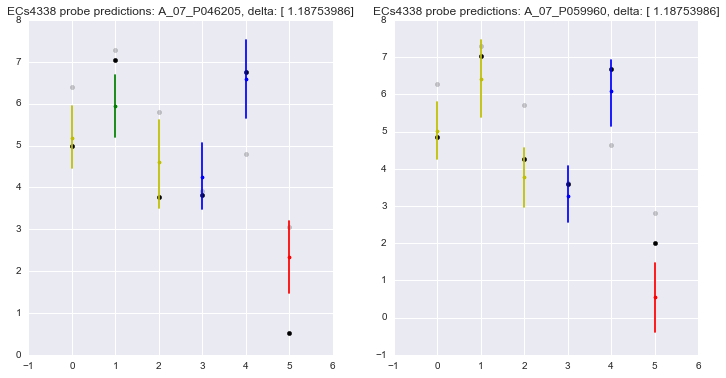

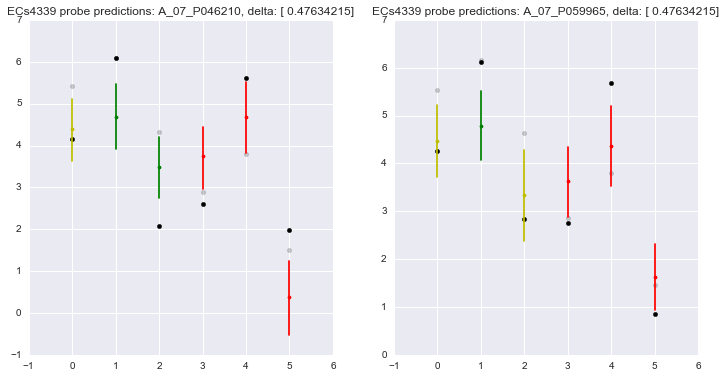

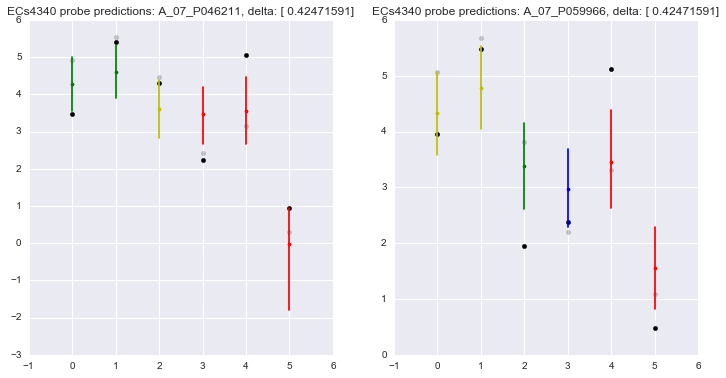

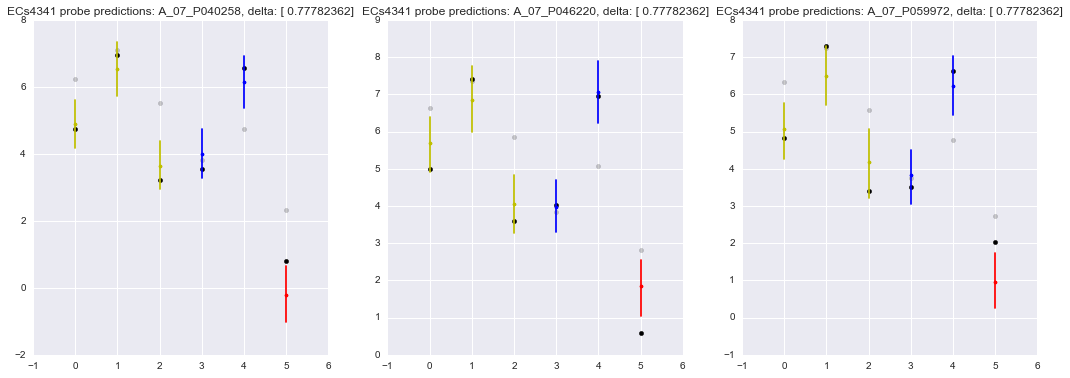

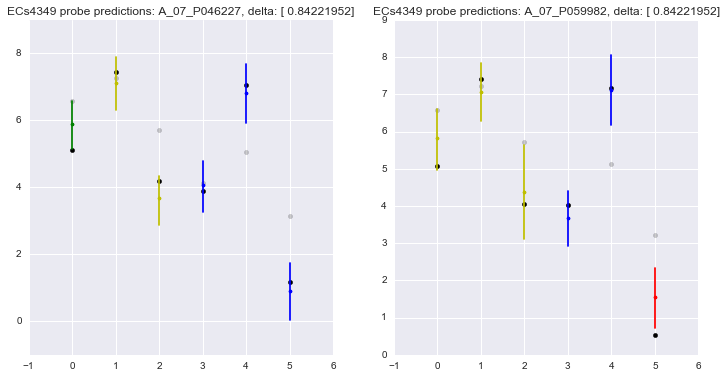

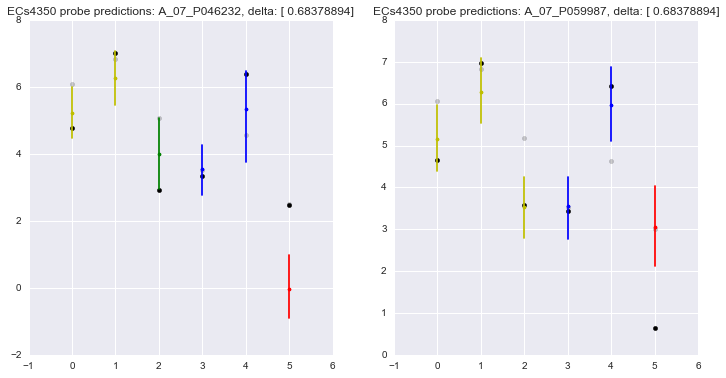

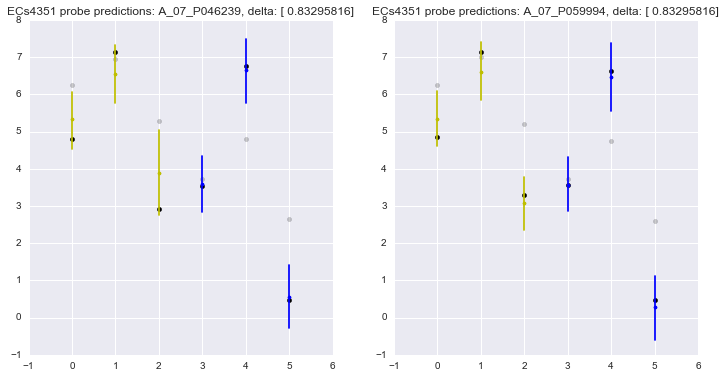

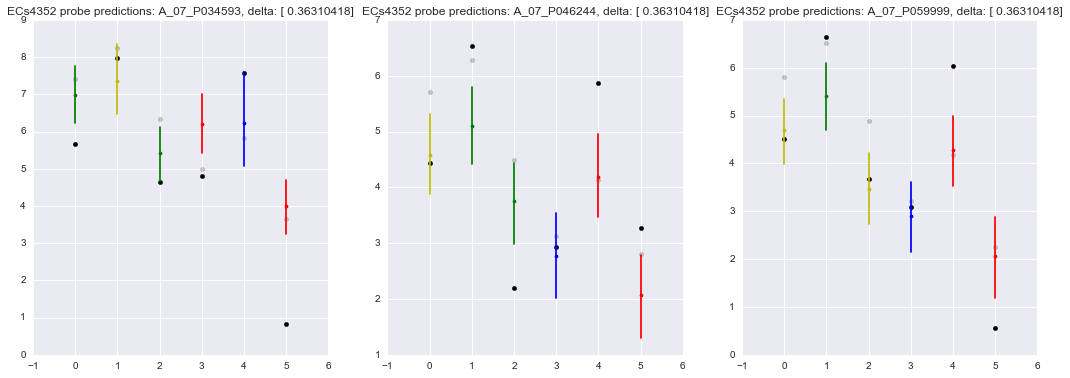

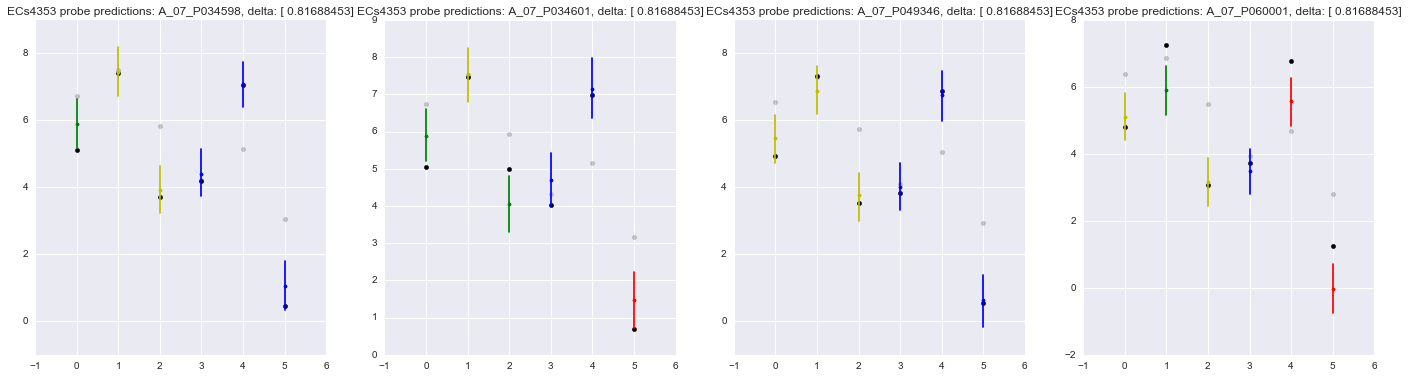

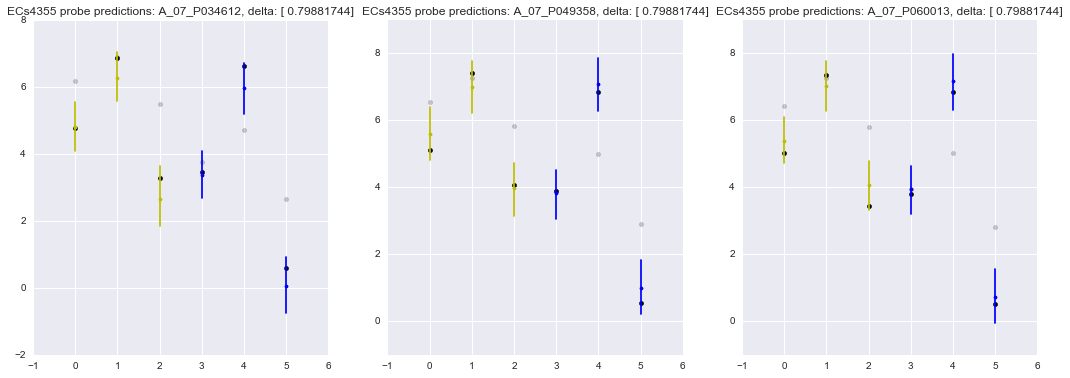

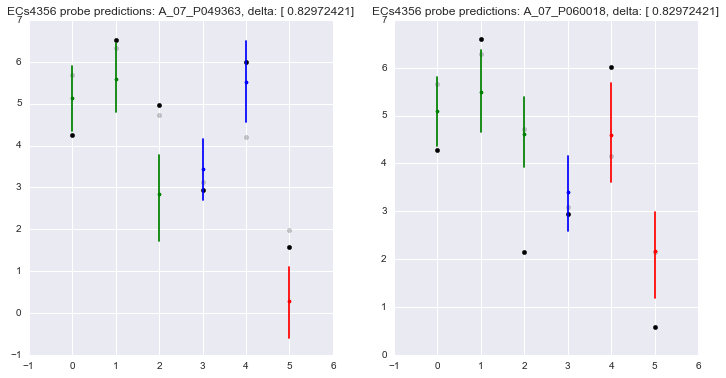

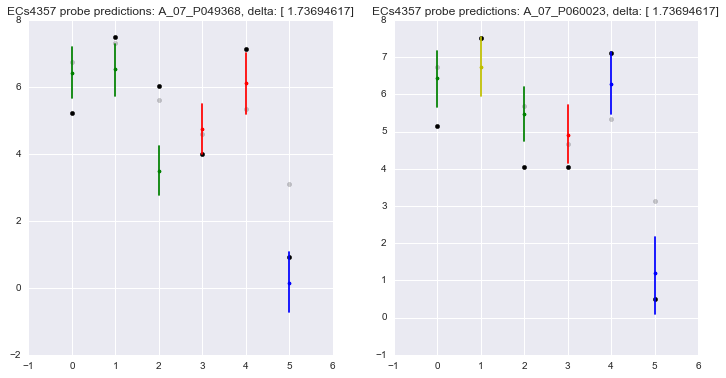

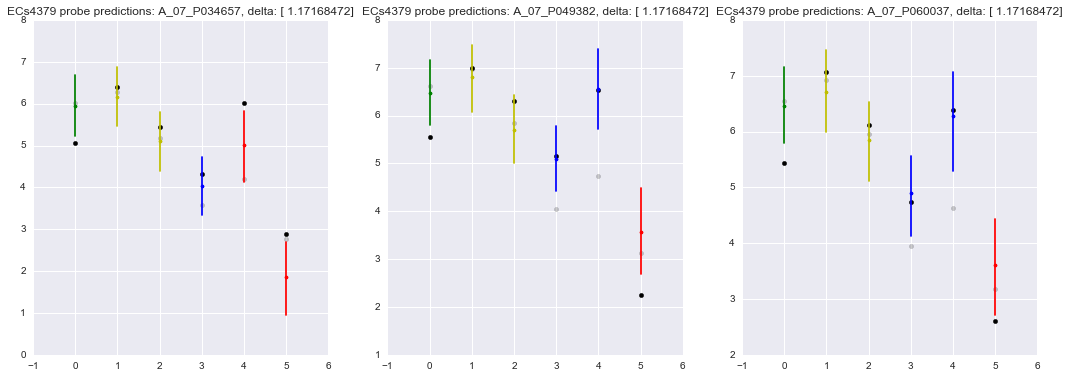

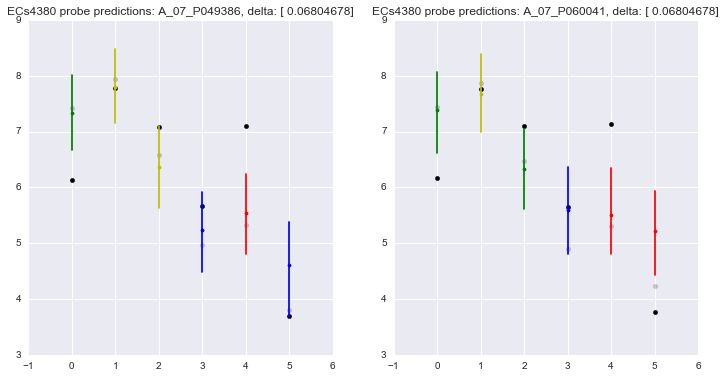

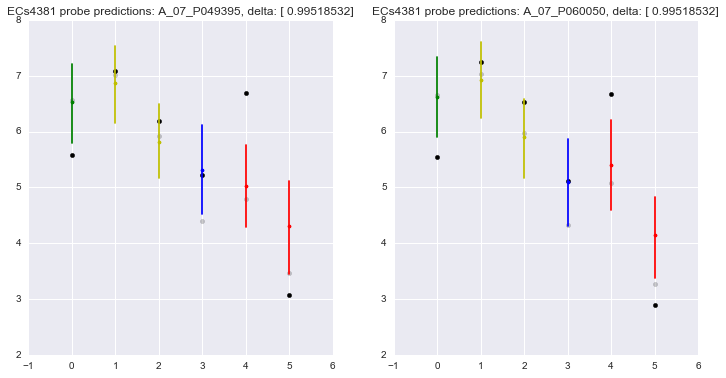

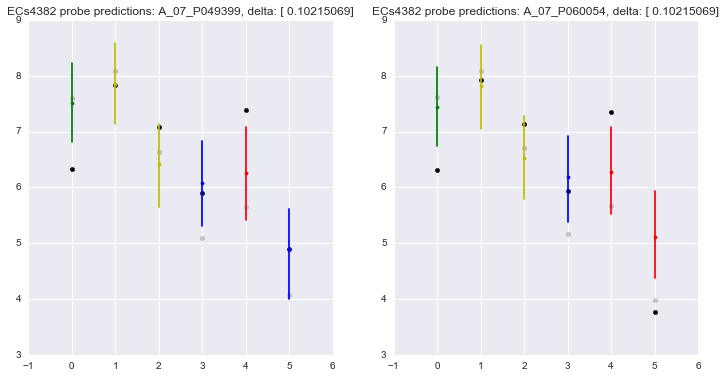

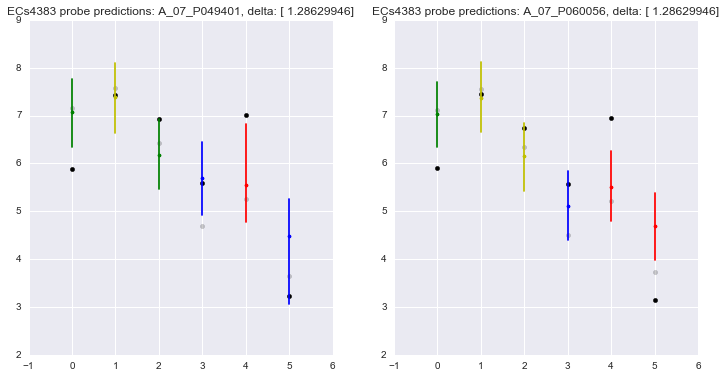

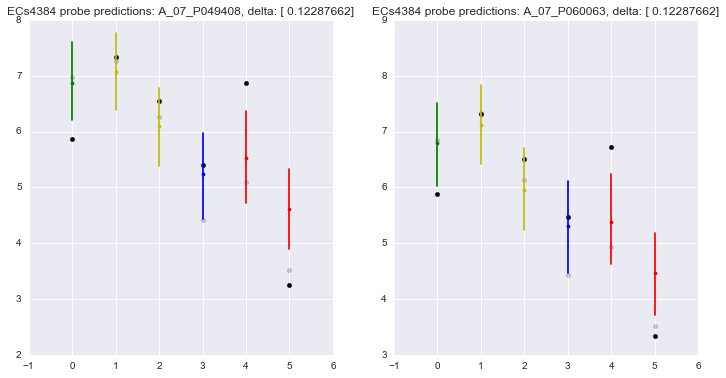

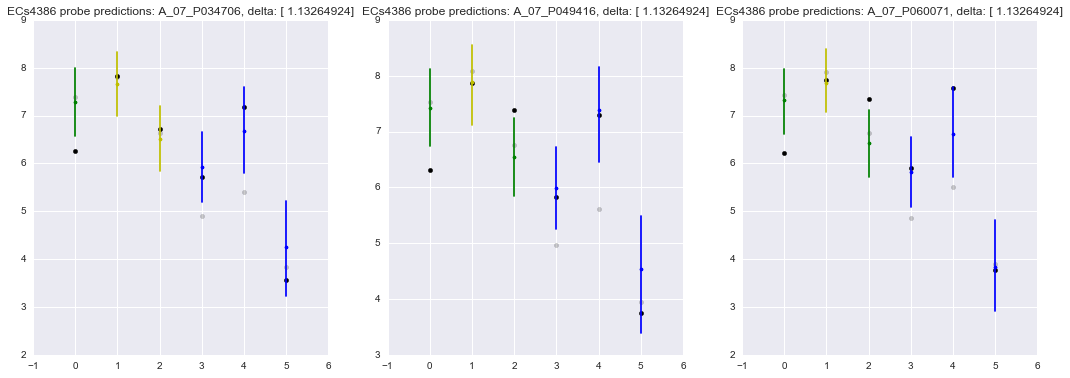

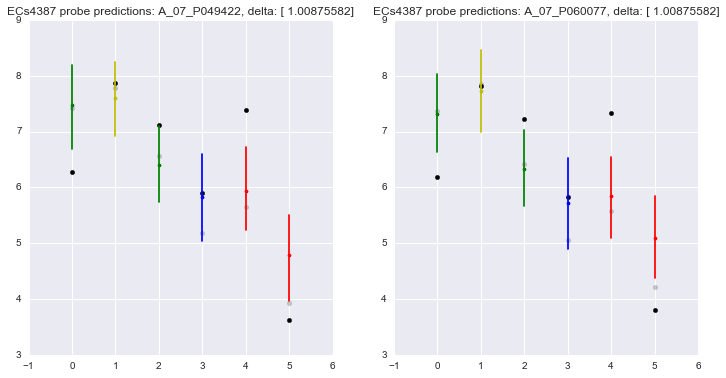

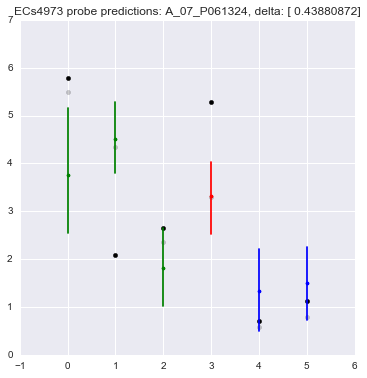

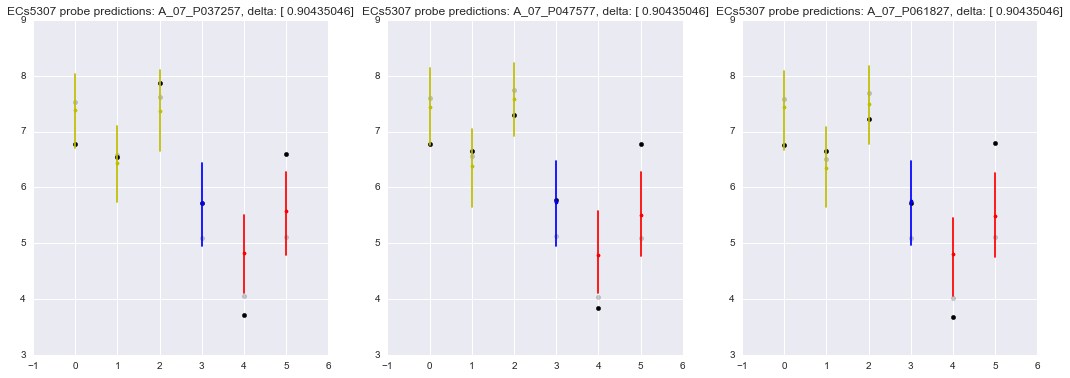

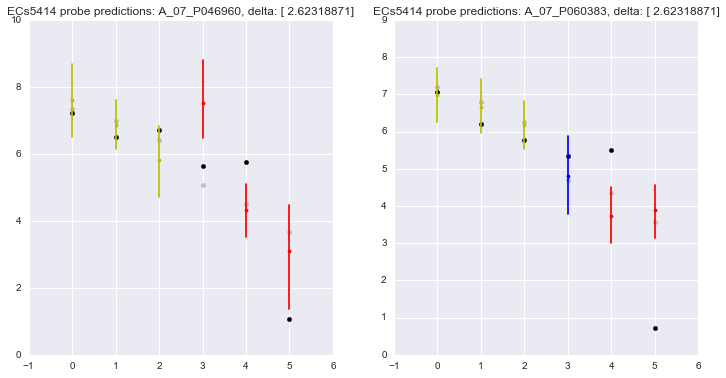

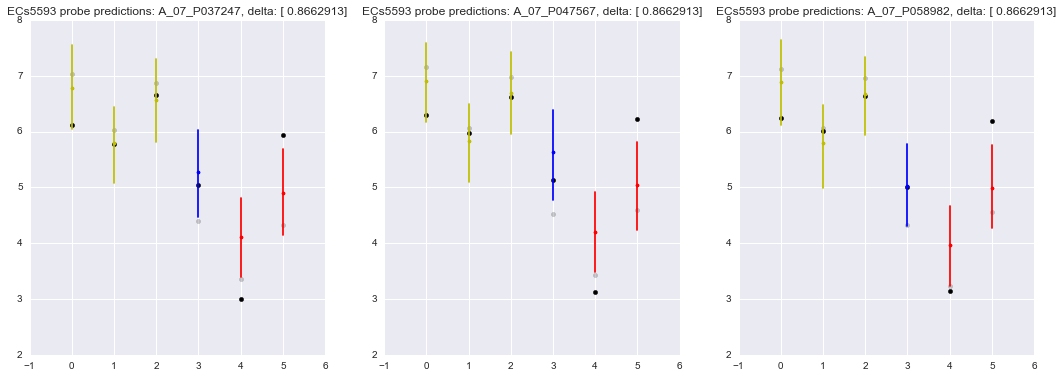

In [20]:
for lt in trt_pos['locus_tag'].unique():
    #print(lt)
    plot_locustag_predictions(trt_pos, lt)

In [21]:
trt_pos[trt_pos['locus_tag'] == "ECs1357"]

,locus_tag,probe,replicate,treatment,log_input,log_output,y_pred_5pc,y_pred_median,y_pred_95pc,d_2.5pc,d_25pc,d_median,d_75pc,d_97.5pc,y_pred_abs_error,y_pred_rel_error,pred_success
22146,ECs1357,A_07_P060331,1,1,5.391944,5.945018,3.604149,6.055985,9.477267,0.409551,0.628914,0.73244,0.832085,1.048997,0.110967,0.018665,True
22147,ECs1357,A_07_P060331,2,1,4.932095,6.101650,2.798997,3.813449,4.783944,0.409551,0.628914,0.73244,0.832085,1.048997,-2.288201,-0.375014,False
22148,ECs1357,A_07_P060331,2,0,7.529214,6.919853,6.407768,7.259676,8.019243,0.409551,0.628914,0.73244,0.832085,1.048997,0.339823,0.049108,True
22149,ECs1357,A_07_P060331,3,0,6.830039,6.483957,5.867605,6.618314,7.346500,0.409551,0.628914,0.73244,0.832085,1.048997,0.134358,0.020722,True
22150,ECs1357,A_07_P060331,3,1,3.973043,0.397170,3.701036,4.464847,5.351228,0.409551,0.628914,0.73244,0.832085,1.048997,4.067677,10.241647,False
22151,ECs1357,A_07_P060331,1,0,7.896378,7.734100,6.791041,7.573784,8.341597,0.409551,0.628914,0.73244,0.832085,1.048997,-0.160317,-0.020729,True


NameError: name 'positives' is not defined

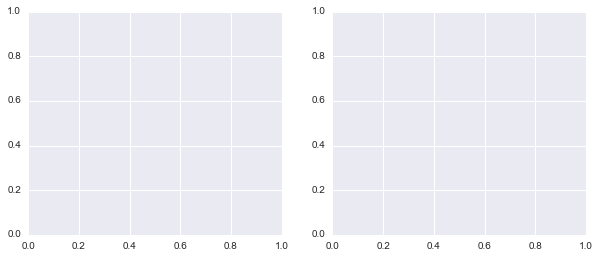

In [22]:
# Plot error and relative error against mean estimate for delta
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.scatter(positives['d_mean'], positives['y_pred_error'], alpha=0.1)
ax1.set_xlabel('mean(delta)')
ax1.set_ylabel('error')
ax1.set_title('Prediction error')

ax2.scatter(positives['d_mean'], positives['y_pred_relative_error'], alpha=0.1)
ax2.set_xlabel('mean(delta)')
ax2.set_ylabel('relative error')
ax2.set_title('Prediction relative error');

In [ ]:
# Visualise distribution of errors by probe, for each locus tag.
fig, ax1 = plt.subplots(1, 1, figsize=(12, 4))
errplt = sns.boxplot(x=positives['locus_tag'], y=positives['y_pred_relative_error'], ax=ax1)
for item in errplt.get_xticklabels():
    item.set_rotation(90)
    item.set_fontsize(8)
errplt.set_title("Relative predicted error by probe (positive treatment effects)");

All of the genewise errors have distributions close to zero relative error, taken over all probes. However, some genes have very noisy responses (one or a few probes with large relative error).

In [ ]:
positives.loc[positives['locus_tag'] == 'ECs1172'][['probe', 'log_output', 'y_pred_5pc',
                                                    'y_pred_median', 'y_pred_95pc', 'd_median',
                                                    'y_pred_relative_error']].sort_values('probe')

In [ ]:
def plot_probe_predictions(locustag, df):
    """Plot prediction range and measured value for a specific gene"""
    ltdata = df.loc[df['locus_tag'] == locustag].sort_values(['probe', 'treatment', 'replicate'])
    plt.scatter(range(len(ltdata)), ltdata['log_output'], color='k')
    for idx, obs, plo, pmd, phi in zip(range(len(ltdata)),
                                       ltdata['log_output'],
                                       ltdata['y_pred_5pc'],
                                       ltdata['y_pred_median'],
                                       ltdata['y_pred_95pc']):
        if plo < obs < phi:
            lcolor = 'b-'
            pcolor = 'b.'
        else:
            lcolor = 'r-'
            pcolor = 'r.'
        plt.plot([idx, idx], [plo, phi], lcolor)
        plt.plot([idx, idx], [pmd, pmd], pcolor)
    plt.xticks(range(len(ltdata)), ltdata['probe'], rotation=90)
    plt.xlim(-1, len(ltdata))
    plt.title("Probe predictions: {0}, delta: {1}".format(locustag, ltdata['d_median'].unique()))

In [ ]:
plot_probe_predictions('ECs3501', trt_pos)

In [ ]:
# Visualise distribution of delta estimates by probe, for each locus tag.
fig, ax1 = plt.subplots(1, 1, figsize=(12, 4))
deltaplt = sns.boxplot(x=positives['locus_tag'], y=positives['d_median'], ax=ax1)
for item in deltaplt.get_xticklabels():
    item.set_rotation(90)
    item.set_fontsize(8)
deltaplt.set_title("Relative predicted error by probe (positive treatment effects)");